<h1><b>Comparing the similiraty of neigborhood between New York and Toronto</b></h1><br>
<h3>fitst we dpwnload and import all the needed libraries</h3>

In [ ]:
!pip install geocoder
!pip install folium 
!pip install bs4

from bs4 import BeautifulSoup
import requests
import numpy as np 
import scipy

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import json # library to handle JSON files

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import AgglomerativeClustering


import folium # map rendering library
import pylab
import scipy.cluster.hierarchy
import pylab
from matplotlib import pyplot as plt
import scipy
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import MinMaxScaler

<h2>New York Data</h2>
<h4>for the new york data we are gonna use the same json file  
    we used in week 3 lab from this course and retreive its data into a pandas dataframe</h4>

In [25]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
NY_neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
NY_neighborhoods = pd.DataFrame(columns=column_names)
for data in NY_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_neighborhoods = NY_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
NY_neighborhoods = NY_neighborhoods[NY_neighborhoods['Borough'].astype(str) == 'Bronx']
NY_neighborhoods.reset_index(drop=True,inplace = True)
NY_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


<h2>Toronto Data</h2>
<h4>for the Toronto data we are going to construct the dataframe in three steps:</h4>
<h5>firstly we are going to use beautiful soup library to srape toronto neighbor hood data from the wikipedia page</h5>

In [26]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_url,'html')
neighborhood_tabal = soup.find('table',{'class':'wikitable sortable'})
ColumnsNames = []
columns_names_holder = neighborhood_tabal.findAll('th')
for name in columns_names_holder:
    ColumnsNames.append(name.text.rstrip())
    
toronto_neighborhood = pd.DataFrame(columns = ColumnsNames)


<h5>secondly we are going to do some cleaning to the data by removing all neigborhoods that are not assigned to a borough and then group all neighborhoods that have the same postal code</h5>

In [27]:
values = neighborhood_tabal.findAll('td')
length = len(values)
i = 0
while i < length:
    neigborhood = values[i + 2].text.rstrip()
    if neigborhood == 'Not assigned':
        neigborhood = values[i + 1].text.rstrip()        
    toronto_neighborhood = toronto_neighborhood.append({'Postcode': values[i].text.rstrip(), 'Borough' : values[i+1].text.rstrip() , 'Neighborhood' : values[i+2].text.rstrip()},ignore_index = True)
    i = i + 3
toronto_neighborhood = toronto_neighborhood[toronto_neighborhood['Borough'] != 'Not assigned']
toronto_neighborhood.reset_index(drop=True,inplace = True)
#https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value
toronto_neighborhood =  toronto_neighborhood.groupby(['Postcode','Borough'])['Neighborhood'].apply(','.join).reset_index()
toronto_neighborhood.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


<h5>finally we are going to add the lattitude and longitude for each neigborhood using the Geospatial_data file provided in the 3rd week assignment</h5>

In [28]:
df = pd.read_csv('Geospatial_data')
df.set_index('Postal Code',inplace = True)
toronto_neighborhood['Latitude'] =''
toronto_neighborhood['Longitude'] = ''
for i in range(toronto_neighborhood.shape[0]):
    toronto_neighborhood.at[i,'Latitude'] = df.loc[toronto_neighborhood.loc[i,'Postcode'],'Latitude']
    toronto_neighborhood.at[i,'Longitude'] = df.loc[toronto_neighborhood.loc[i,'Postcode'],'Longitude']
toronto_neighborhood.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.8067,-79.1944
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.7845,-79.1605
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.7636,-79.1887
3,M1G,Scarborough,Woburn,43.771,-79.2169
4,M1H,Scarborough,Cedarbrae,43.7731,-79.2395


In [29]:
myFilter = toronto_neighborhood['Borough'].str.contains(pat = 'Toronto')
toronto_neighborhood = toronto_neighborhood[myFilter]
toronto_neighborhood.reset_index(inplace = True)
toronto_neighborhood.drop('index',axis = 1,inplace = True)
toronto_neighborhood.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.6764,-79.293
1,M4K,East Toronto,"The Danforth West,Riverdale",43.6796,-79.3522
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.669,-79.3156
3,M4M,East Toronto,Studio District,43.6595,-79.3409
4,M4N,Central Toronto,Lawrence Park,43.728,-79.3888


<h3>Here we construct a function to retrieve all venues around a specific location whithin a specific radius</h3>

In [30]:
CLIENT_ID = 'GYDUYW4SB4BUA2R3I0AZ5CKUVOWLPSHETFFY31NEHKTOT0I5'
CLIENT_SECRET = 'WPFYAEWTAXVRFQAXZCMFUVWHVCZM2022ZJL53PHJPJAJUJXN'
VERSION = '20200119'
LIMIT = 100
radius = 700
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h3>In this section we merge the two dataframes that contains the neighborhoods of both New York and Toronto into one dataframe and then we extract the nearby venues for each neighborhood </h3>

In [31]:
torontoTemp = toronto_neighborhood[['Borough','Postcode','Latitude', 'Longitude']]
torontoTemp.columns = ['Borough','Neighborhood','Latitude', 'Longitude']
all_neighborhood = pd.concat([torontoTemp , NY_neighborhoods], ignore_index=True)
#all_neighborhood

In [32]:
toronto_neighborhood_venues = getNearbyVenues(names=toronto_neighborhood['Postcode'],latitudes = toronto_neighborhood['Latitude'],longitudes=toronto_neighborhood['Longitude'])
toronto_neighborhood_venues['Neighborhood'] = toronto_neighborhood_venues['Neighborhood'].astype(str) + " - TO" 
toronto_neighborhood_venues.to_csv('Toronto_Named_Venues',index = False)
#toronto_neighborhood_venues = pd.read_csv('Toronto_Venues')
#toronto_neighborhood_venues.head()

NY_neighborhoods_venues = getNearbyVenues(names=NY_neighborhoods['Neighborhood'],latitudes=NY_neighborhoods['Latitude'],longitudes=NY_neighborhoods['Longitude'])
NY_neighborhoods_venues['Neighborhood'] = NY_neighborhoods_venues['Neighborhood'].astype(str) + " - NY" 
NY_neighborhoods_venues.to_csv('Bronx_Venues',index = False)
#NY_neighborhoods_venues = pd.read_csv('NY_Venues')
#NY_neighborhoods_venues.head()

all_venues = pd.concat([toronto_neighborhood_venues , NY_neighborhoods_venues], ignore_index=True)
#all_venues

<h2><b>Feature Extraction</b></h2>
<h4>In this section we use one hot encoding on the venues dataframe and then extract the 7 most common venues for in each neighborhood   so we can make use it as our features</h4>

In [33]:
all_venues_onehot_encoding = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")
all_venues_onehot_encoding=all_venues_onehot_encoding.rename(columns = {'Neighborhood':'neighborhood As Venue'})
all_venues_onehot_encoding.insert(0,'Neighborhood',all_venues['Neighborhood'])
all_venues_onehot_encoding.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mattress Store,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,neighborhood As Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Re

In [34]:
allVenues_grouped = all_venues_onehot_encoding.groupby('Neighborhood').mean().reset_index()

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = allVenues_grouped['Neighborhood']

for ind in np.arange(allVenues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(allVenues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Allerton - NY,Pizza Place,Chinese Restaurant,Deli / Bodega,Supermarket,Breakfast Spot,Fast Food Restaurant,Market
1,Baychester - NY,Donut Shop,Fried Chicken Joint,Arcade,Spanish Restaurant,Pet Store,Men's Store,Fast Food Restaurant
2,Bedford Park - NY,Chinese Restaurant,Diner,Pizza Place,Deli / Bodega,Mexican Restaurant,Supermarket,Sandwich Place
3,Belmont - NY,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Bank,Donut Shop,Liquor Store
4,Bronxdale - NY,Gym,Italian Restaurant,Performing Arts Venue,Park,Paper / Office Supplies Store,Chinese Restaurant,Mexican Restaurant


<h3>In this final section we construct our feature set and scale it using min-max scalar and then we construct our model and the feature to it and then we plot our dendrogram in order to inspect our results.</h3>

In [36]:
allVenues_feature_set = allVenues_grouped.drop('Neighborhood', 1)
features = allVenues_feature_set.values
min_max_scaler = MinMaxScaler()
feature_matrix = min_max_scaler.fit_transform(features)

length = feature_matrix.shape[0]
Distance = scipy.zeros([length,length])
for i in range(length):
    for j in range(length):
        Distance[i,j] = scipy.spatial.distance.euclidean(feature_matrix[i], feature_matrix[j])
linkage = scipy.cluster.hierarchy.linkage(Distance, 'average')
max_depth = 4
clusters = scipy.cluster.hierarchy.fcluster(linkage, max_depth, criterion='distance')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # This is added back by InteractiveShellApp.init_path()


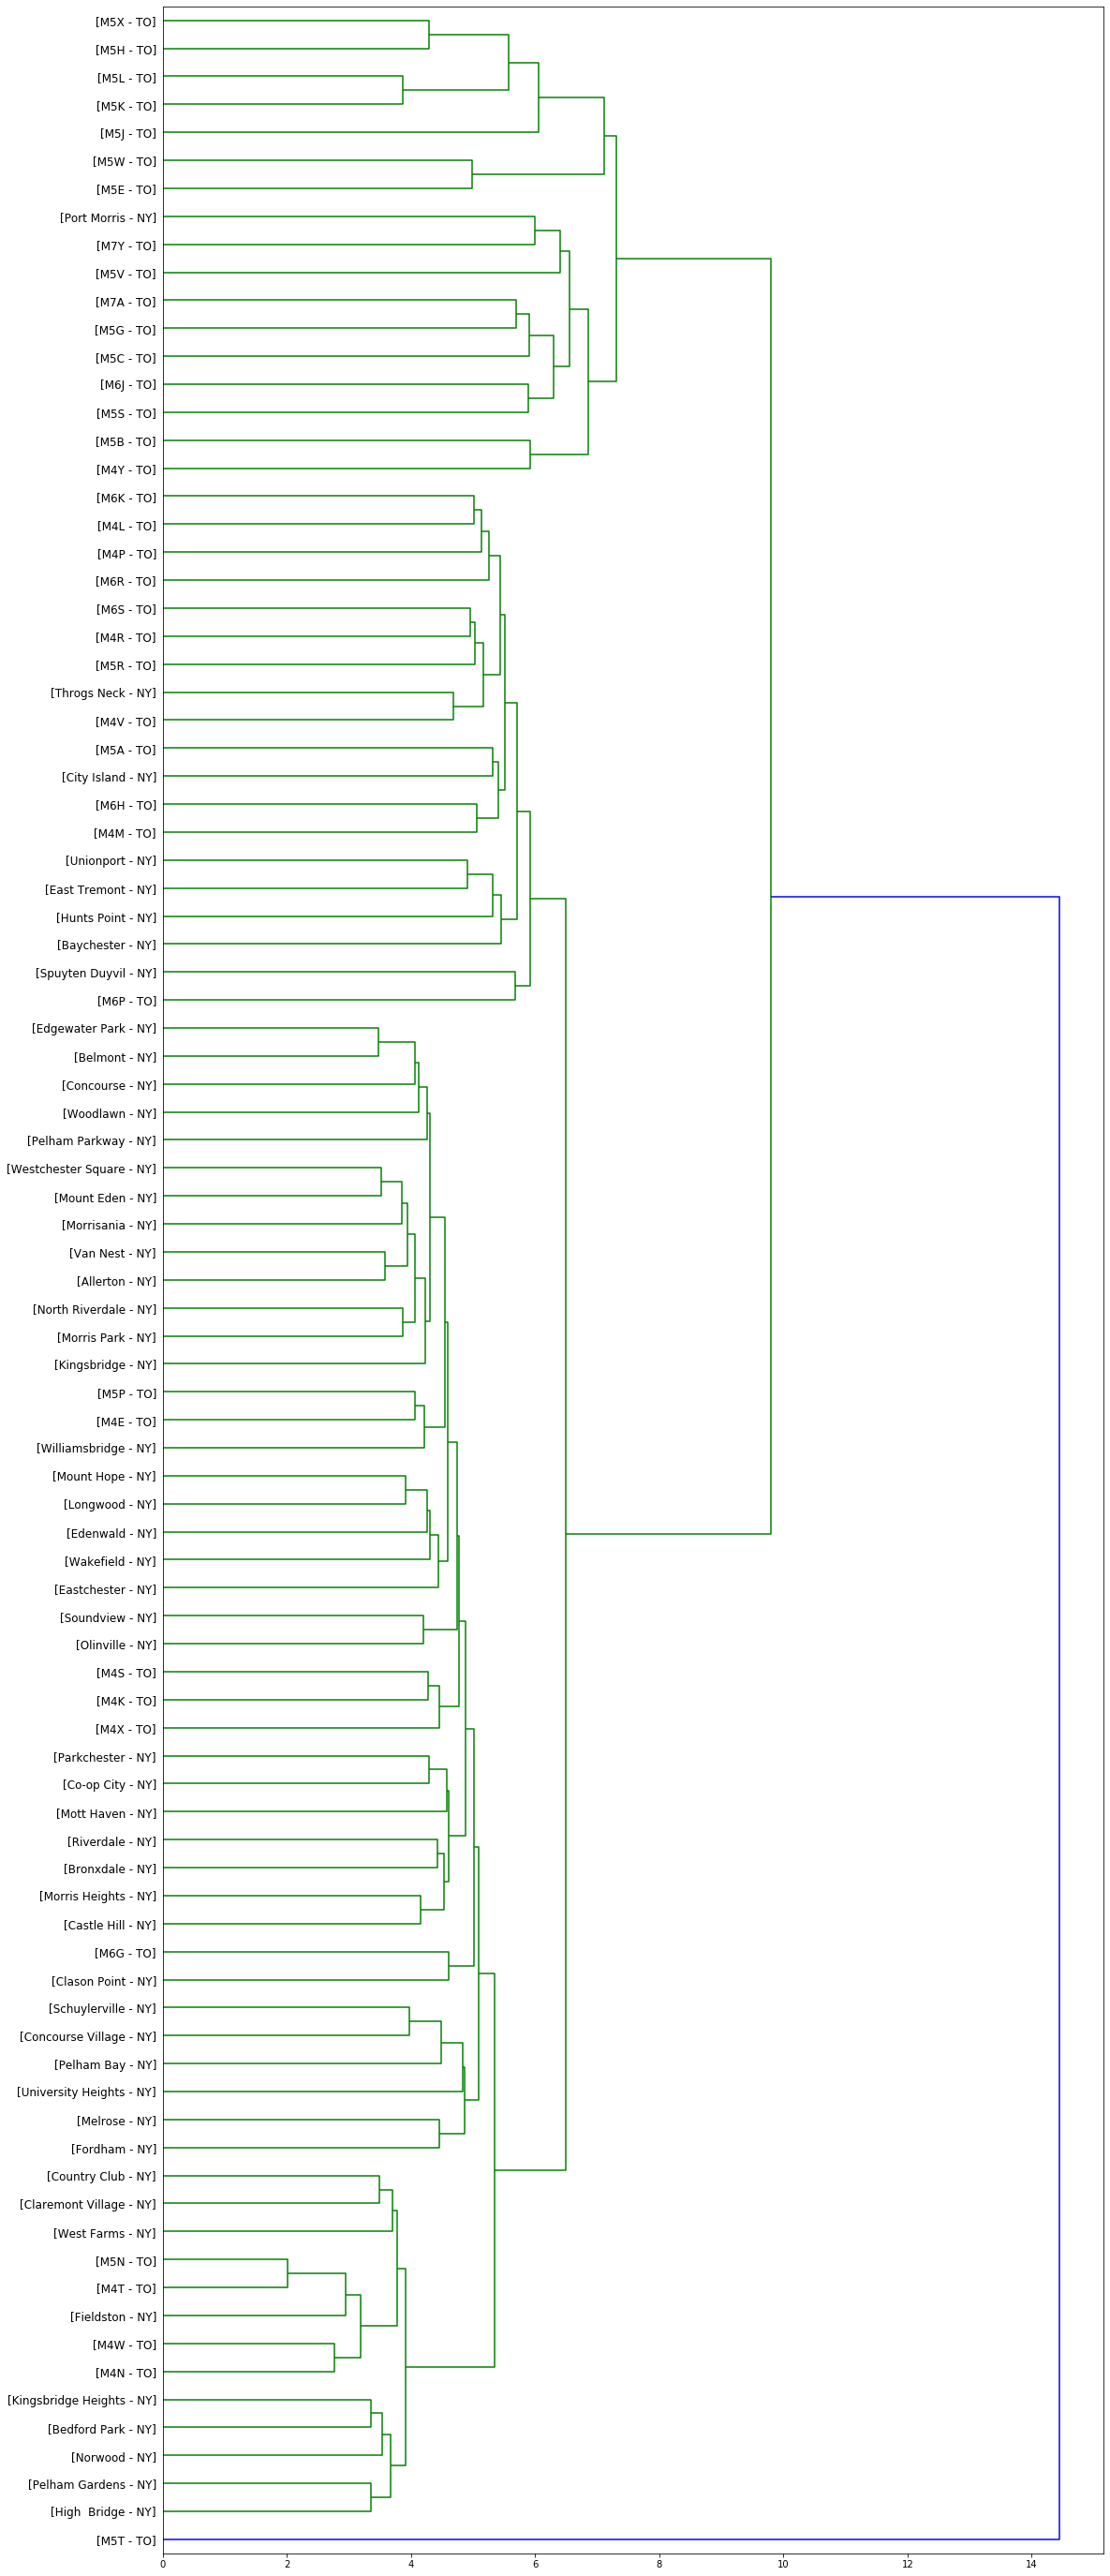

In [37]:
fig = pylab.figure(figsize=(18,50))
def leafLabels(id):
    return '[%s]' % (allVenues_grouped['Neighborhood'][id])
    
dendro = hierarchy.dendrogram(linkage,  leaf_label_func=leafLabels, leaf_rotation=0, leaf_font_size =12, orientation = 'right')
plt.gcf()
plt.savefig('BronxToronto result')